In [1]:
def bound01(num):
    return (num if num < 1 else 1) if num > 0 else 0

def average(nums):
    return bound01(sum(nums) / len(nums))

mean = average # alias

## Read Groundtruth, Events and False Rates

In [2]:
import os
import pandas as pd

# --- Path Setting ---
CLIENT_NUM = 20
# ERROR_RATE = "32"
CONNECTION_ERROR_RATE = "2775" # 0.01, 0.0000
LABELED_CENTERS_PATH = "./data/SF/centers_100_labeled.csv"
EVENTS_DIR_PATH = f"./data/SF/event_SF_{CLIENT_NUM}"
FALSE_RATES_PATH = "./data/SF/error_rates_for_each_client.csv"
LOG_DIR = "./data/log/log_{}_{}".format(CLIENT_NUM, CONNECTION_ERROR_RATE)
# LOG_DIR = "./data/log/log"

# Read Groundtruth
centers = pd.read_csv(LABELED_CENTERS_PATH, dtype={"cluster-id": object})
real_centers = centers.loc[centers["traffic-light"] >= 1, ["cluster-id"]]
real_centers = set(real_centers["cluster-id"].to_list())
print("real_centers_num:", len(real_centers))
# print("total_centers_num:", len(centers))

# Read Events (of clients)
event_set = dict() # indexed by slaves' name
for _, _, files in os.walk(EVENTS_DIR_PATH):
    for file in files:
        name = os.path.splitext(os.path.basename(file))[0]
        path = os.path.join(EVENTS_DIR_PATH, file)
        event_set[name] = pd.read_csv(path, dtype={"identifier": object})
        event_set[name].set_index("identifier", inplace=True)

print("clients_num:", len(event_set))

# Read False Rates
false_rates = pd.read_csv(FALSE_RATES_PATH, dtype={"id": object}, index_col="id")["error_rate"]
false_rates.name = "false_rate"

real_centers_num: 55
clients_num: 20


## Process Log File

In [3]:
import os
import re

def read_slave_log(path):
    """
    extract uid, name and its trustworthiness history from a slave's log
    """
    name = os.path.splitext(os.path.basename(path))[0]
    file = open(path, 'r')
    line = file.readline()
    uid_match = re.search(r"self.uid: (\d+)", line)
    uid = int(uid_match.group(1))

    trustworthiness_history = list()
    while line:
        if "update_trustworthiness_with" in line:
            match = re.search(r"call: (.+),", line)
            trustworthiness = float(match.group(1))
            trustworthiness_history.append(trustworthiness)

        line = file.readline()
    
    file.close()
    return uid, name, trustworthiness_history

def read_master_log(path):
    """
    extract **event confidence** and **leader-board** from master's log
    """
    file = open(path, 'r')
    event_identifiers = dict() # { event_identifier: eid }
    event_confidences = dict() # { eid: true_confidence }
    leaderboard = list() # [uid] ascendingly
    iter_counter = 0

    line = file.readline()
    match = re.search(r"\d+", line)
    line = line[match.end():]
    match = re.search(r"\d+", line)
    h_start = int(match.group())
    line = line[match.end():]
    match = re.search(r"\d+", line)
    m_start = int(match.group())
    line = line[match.end():]
    match = re.search(r"\d+", line)
    s_start = int(match.group())
    line = line[match.end():]
    print(f'start at: {h_start}:{m_start}:{s_start}')

    while line:
        if "Identifier Eid Map" in line:
            match = re.search(r"(([a-zA-Z0-9]+): (\d+))", line)
            while match:
                event_identifier = match.group(2)
                eid = match.group(3)
                event_identifiers[event_identifier] = eid
                line = line[match.end():]
                match = re.search(r"(([a-zA-Z0-9]+): (\d+))", line)
        elif "event_confidence" in line:
            match = re.search(r"(([a-zA-Z0-9]+): (\d+))", line)
            while match:
                eid = match.group(2)
                confidence = match.group(3)
                event_confidences[eid] = float(confidence)
                line = line[match.end():]
                match = re.search(r"(([a-zA-Z0-9]+): ([\d|\.]+))", line)
        elif "leader-board" in line:
            line = line[24:]
            match = re.search(r"\d+", line)
            while match:
                uid = match.group()
                leaderboard.append(uid)
                line = line[match.end():]
                match = re.search(r"\d+", line)
        elif "Iteration, round_ith" in line:
            iter_counter += 1
        elif "Traffic in bytes" in line:
            tmp_line = line
            match = re.search(r"\d+", line)
            line = line[match.end():]
            match = re.search(r"\d+", line)
            h_end = int(match.group())
            line = line[match.end():]
            match = re.search(r"\d+", line)
            m_end = int(match.group())
            line = line[match.end():]
            match = re.search(r"\d+", line)
            s_end = int(match.group())
            h_cost, m_cost, s_cost = h_end - h_start, m_end - m_start, s_end - s_start
            total_time_cost = h_cost * 3600 + m_cost * 60 + s_cost
            print(f'end at: {h_end}:{m_end}:{s_end}')

            line = tmp_line[24:]
            match = re.search(r"\d+", line)
            in_bytes = match.group()
            line = line[match.end():]
            match = re.search(r"\d+", line)
            out_bytes = match.group()
        line = file.readline()

    file.close()
    # leaderboard = leaderboard[5:] # skip date info numbers
    return event_identifiers, event_confidences, leaderboard, (in_bytes, out_bytes), total_time_cost, iter_counter

In [4]:
master = None
event_identifiers, event_confidences_fed, leaderboard = None, None, None
slaves = dict() # indexed by slaves' name
print(LOG_DIR)
for _, _, files in os.walk(LOG_DIR):
    for file in files:
        file = os.path.join(LOG_DIR, file)
        if file.endswith("master.log"):
            event_identifiers, event_confidences_fed, leaderboard, network_io, total_seconds, iter_n = read_master_log(file)
        else:
            uid, name, trustworthiness_history = read_slave_log(file)
            slaves[name] =  { "uid": uid, "trustworthiness_history": trustworthiness_history }

print("The number of slaves:", len(slaves))
print("The number of survived events:", len(event_confidences_fed))
print("The number of survived trustworithiness:", len(leaderboard))
print(f"Traffic in bytes: in => {network_io[1]}, out => {network_io[0]}")
print(f"Total time cost in second: {total_seconds}")
print(f"#iter: {iter_n}")

./data/log/log_20_2775
start at: 13:31:41
end at: 13:31:56
The number of slaves: 20
The number of survived events: 96
The number of survived trustworithiness: 7
Traffic in bytes: in => 5647759, out => 3772807
Total time cost in second: 15
#iter: 3


## Hellinger Distance

In [5]:
import numpy as np

def hellinger_distance(real_dist, fed_dist):
    assert len(real_dist) == len(fed_dist)
    real_dist, fed_dist = np.array(real_dist), np.array(fed_dist)
    return np.sqrt(1-np.sum(np.sqrt(real_dist * fed_dist)))

# Central Truth Discovery

In [6]:
import numpy as np
import random
from copy import deepcopy

class Event(object):
    def __init__(self, claim, identifier):
        # assert false_rate >= 0 and false_rate <= 1, "false_rate out of range([0, 1])"
        self.identifier = identifier
        # true_possibility = 1.0 - false_rate
        self.claim = claim
        self.confidence = np.array([0.5, 0.5])

class Client(object):
    DEFAULT_TRUSTWORTHINESS = 0.9

    def __init__(self, name, error_rate, owned_events): 
        # owned_events: dict(owned event_identifiers: claim)
        self.name = name
        self.trustworthiness = self.DEFAULT_TRUSTWORTHINESS # for comparision
        self.error_rate = error_rate # the possibility to provide a wrong claim
        self.events = {identifier: Event(claim, identifier) for identifier, claim in owned_events.items()}

    def update_trustworthiness(self):
        possibilities = [e.confidence[0] if e.claim else e.confidence[1] for e in self.events.values()]
        self.trustworthiness = average(possibilities)

    def claim(self, event_identifier):
        claim = deepcopy(self.events[event_identifier])
        poss = random.random()
        if poss < self.error_rate:
            claim.claim = not claim.claim
        return claim

def trustworthiness_computations(clients):
    for client in clients:
        client.update_trustworthiness()

def event_confidence_computation(clients, event_identifier):
    clients = [c for c in clients if event_identifier in c.events]
    claims = {c.name: c.claim(event_identifier) for c in clients}
    trustworthiness = [c.trustworthiness if claims[c.name].claim else (1 - c.trustworthiness) for c in clients]
    true_possibility = average(trustworthiness)
    confidence = np.array([true_possibility, 1.0 - true_possibility])

    for client in clients:
        client.events[event_identifier].confidence = confidence
    return confidence

def event_confidence_computations(event_identifiers, clients):
    confidences = dict()
    for event_identifier in event_identifiers:
        confidences[event_identifier] = event_confidence_computation(clients, event_identifier)
    return confidences # { event_identifier: confidence }

# def update_event_list(clients, claims):
#     for c in clients:
#         if c.name in claims:
#             c.event_list.append(claims[c.name])

# def average_distance(list_a, list_b):
#     assert len(list_a) == len(list_b)
#     sum = 0
#     for i in range(len(list_a)):
#         sum += abs(list_a[i] - list_b[i])
#     return sum / len(list_a)

def iteration_condition(round_ith, avg_distance):
    return round_ith <= 10 and avg_distance > 0.01

In [7]:
# run simulation
def central_truth_discovery(event_identifiers):
    owned_identifiers = dict() # indexed by name
    for name, events in event_set.items():
        events = events[events["owned"]] # filter out the records that is not owned by this client
        owned_identifiers[name] = events["claim"].to_dict()

    clients = [Client(name, false_rates[name], owned_identifiers[name]) for name in owned_identifiers.keys()]
    round_counter = 0
    avg_dist = 1
    confidences_tmp = dict() # indexed by event_identifier: aggregated true event_confidence
    while iteration_condition(round_counter, avg_dist):
        confidences = event_confidence_computations(event_identifiers, clients)
        trustworthiness_computations(clients)
        round_counter += 1

        if len(confidences_tmp) == 0:
            for identifier, confidence in confidences.items():
                    confidences_tmp[identifier] = confidence
            continue

        dist_sum = 0
        for identifier, confidence in confidences.items():
            if identifier in confidences_tmp:
                dist_sum += abs(confidences_tmp[identifier][0] - confidence[0])
                confidences_tmp[identifier] = confidence
        avg_dist = dist_sum / len(confidences)

    return confidences_tmp

all_event_identifiers = next(iter(event_set.values())).index.to_list()
event_confidences_central = central_truth_discovery(all_event_identifiers)
# pd.DataFrame(event_confidences.values(), event_confidences.keys()).describe()

# Federated Truth Finder


In [8]:
fed_event_true_confidence = {identifier: event_confidences_fed[eid] for identifier, eid in event_identifiers.items() if eid in event_confidences_fed}

# Central Fashion vs. Federated Fashion
## Distribution Distance

In [9]:
import matplotlib.pyplot as plt

def plot_events_true_possibility(confidences):
    x, y = list(confidences.keys()), list(confidences.values())
    plt.bar(x, y)
    plt.xticks(x, x, rotation=90)
    plt.tick_params(labelsize=4)
    plt.ylabel("the possibility when classified as TRUE")
    plt.xlabel("event identifier")

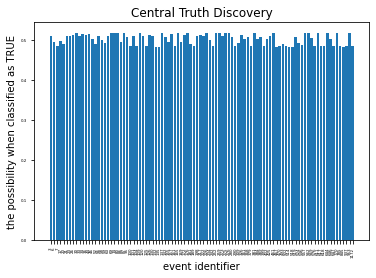

In [10]:
true_possibilities_from_central = {identifier: conf[0] for identifier, conf in event_confidences_central.items()}
plot_events_true_possibility(true_possibilities_from_central)
plt.title("Central Truth Discovery")
plt.show()

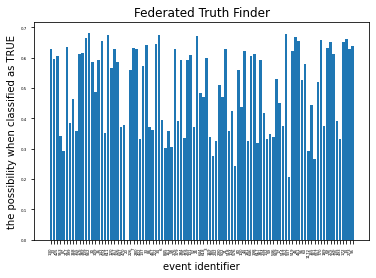

In [11]:
true_possibilities_from_fed = {identifier: event_confidences_fed[eid] for identifier, eid in event_identifiers.items()}
plot_events_true_possibility(true_possibilities_from_fed)
plt.title("Federated Truth Finder")
plt.show()

In [12]:
# assert set(true_possibilities_from_fed.keys()) == set(true_possibilities_from_central.keys())
fed, cen = true_possibilities_from_fed, true_possibilities_from_central
distances = {id: hellinger_distance([fed[id], 1-fed[id]], [cen[id], 1-cen[id]]) for id in fed.keys()}

In [13]:
len(true_possibilities_from_central.keys())

96

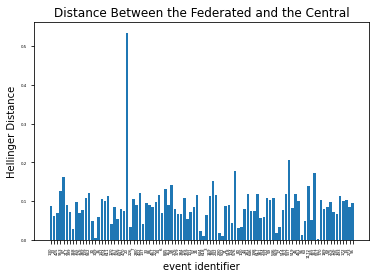

In [14]:
plot_events_true_possibility(distances)
plt.title("Distance Between the Federated and the Central")
plt.ylabel("Hellinger Distance")
plt.show()

In [15]:
pd.Series(distances).describe()

count    96.000000
mean      0.088005
std       0.060298
min       0.002652
25%       0.060742
50%       0.084532
75%       0.107188
max       0.534539
dtype: float64

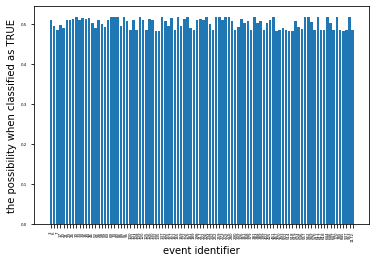

In [16]:
plot_events_true_possibility(true_possibilities_from_central)
def plot_events_true_possibility_both(central, fed, bar_width=1.2, labelsize=4):
    plt.cla()
    import numpy as np
    central_x, central_y = list(central.keys()), list(central.values())
    fed_x, fed_y = list(fed.keys()), list(fed.values())

    assert central_x == fed_x
    x = np.arange(len(central_x)) * 3
    tick_label = central_x
    del fed_x

    plt.bar(x, central_y, width=bar_width, label="central")
    plt.bar(x + bar_width, fed_y, width=bar_width, label="federated")

    plt.xticks(x + bar_width/2, tick_label, rotation=90)
    plt.tick_params(labelsize=labelsize)
    plt.ylabel("the possibility when classified as TRUE")
    plt.xlabel("event identifier")
    plt.legend()
    plt.figure(figsize=(12, 6), dpi=100)
    plt.show()

# plot_events_true_possibility_both(true_possibilities_from_central, true_possibilities_from_fed)

## Accuracy

In [17]:
def calc_acc(true_possibilities):
    accuracies = dict() # indexed by event_identifier
    for identifier, confidence in true_possibilities.items():
        accurate = ((confidence > 0.5 and identifier in real_centers) or (confidence <= 0.5 and identifier not in real_centers))
        accuracies[identifier] = accurate
    return  mean(accuracies.values())

In [18]:
print("mean(accuracies of clients)_central:", calc_acc(true_possibilities_from_central))
print("mean(accuracies of clients)_fed:", calc_acc(true_possibilities_from_fed))

mean(accuracies of clients)_central: 0.9583333333333334
mean(accuracies of clients)_fed: 0.9375
